##### Setup the Environment and Import Dependencies

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
import joblib

In [2]:
# Set Matplotlib style for better visualization
plt.style.use('ggplot')

##### Connect to the Database and Load Data

In [3]:
# 2. Connect to the Database and Load Data
# IMPORTANT: Replace these connection details with your own.
# The format is 'mssql+pyodbc://<username>:<password>@<server_name>/<database_name>?driver=ODBC+Driver+17+for+SQL+Server'
# You may need to install pyodbc: pip install pyodbc
# For trusted connections (Windows Authentication), you can use:
# engine = create_engine('mssql+pyodbc://<server_name>/Healthcare_Analysis?driver=ODBC+Driver+17+for+SQL+Server')
server_name = 'DESKTOP-J3CT656\\SQLEXPRESS'
database_name = 'Healthcare_Analysis'

# A more robust connection string using pyodbc
connection_string = (
    f"DRIVER={{ODBC Driver 17 for SQL Server}};"
    f"SERVER={server_name};"
    f"DATABASE={database_name};"
    f"Trusted_Connection=yes;"
)
# Create the SQLAlchemy engine
# Create the SQLAlchemy engine
try:
    engine = create_engine(f"mssql+pyodbc:///?odbc_connect={connection_string}")
    print("Database connection string created.")
    
    # Attempt a connection to verify it works
    with engine.connect() as connection:
        print("Database connection successful.")

except Exception as e:
    print(f"Error connecting to database: {e}")
    # Exit if the connection fails
    exit()

Database connection string created.
Database connection successful.


In [4]:
# Load data from SQL tables into pandas DataFrames
patients_df = pd.read_sql('SELECT * FROM patients', engine)
admissions_df = pd.read_sql('SELECT * FROM admissions', engine)
diagnoses_df = pd.read_sql('SELECT * FROM diagnoses', engine)
medications_df = pd.read_sql('SELECT * FROM medications', engine)

print("Data loaded successfully into DataFrames.")
print("\n--- Patients Data ---")
print(patients_df.head())
print("\n--- Admissions Data ---")
print(admissions_df.head())

Data loaded successfully into DataFrames.

--- Patients Data ---
   patient_id  age  gender ethnicity admission_type
0           1   34    Male  Hispanic         Urgent
1           2   48    Male     White      Emergency
2           3   74    Male     White      Emergency
3           4   47    Male     Other      Emergency
4           5   45  Female     Black        Newborn

--- Admissions Data ---
   admission_id  patient_id admission_date discharge_date  length_of_stay  \
0             1          47     2025-04-21     2025-04-23               2   
1             2          86     2025-04-08     2025-04-19              11   
2             3          60     2025-04-24     2025-05-02               8   
3             4          26     2025-02-07     2025-02-08               1   
4             5          32     2025-02-07     2025-02-18              11   

  discharge_disposition  
0               Expired  
1                 Rehab  
2                 Rehab  
3                  Home  
4    

##### 3. Exploratory Data Analysis (EDA)

In [5]:
print("Admissions DataFrame Info")
admissions_df.info()

Admissions DataFrame Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   admission_id           500 non-null    int64 
 1   patient_id             500 non-null    int64 
 2   admission_date         500 non-null    object
 3   discharge_date         500 non-null    object
 4   length_of_stay         500 non-null    int64 
 5   discharge_disposition  500 non-null    object
dtypes: int64(3), object(3)
memory usage: 23.6+ KB


In [6]:
print("Discharge Disposition Distribution")
print(admissions_df['discharge_disposition'].value_counts())

Discharge Disposition Distribution
discharge_disposition
Rehab               133
Expired             126
Nursing Facility    126
Home                115
Name: count, dtype: int64


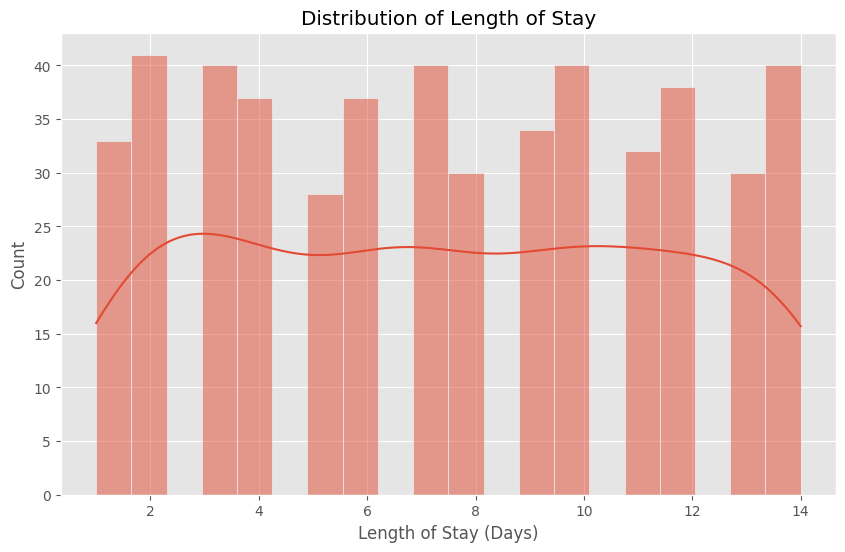

In [7]:
# Visualize the distribution of the length of stay
plt.figure(figsize=(10, 6))
sns.histplot(admissions_df['length_of_stay'], bins=20, kde=True)
plt.title('Distribution of Length of Stay')
plt.xlabel('Length of Stay (Days)')
plt.ylabel('Count')
plt.show()

##### 4. Feature Engineering: Define Readmission

In [8]:
# A patient is considered readmitted if they have a subsequent admission within 30 days of being discharged from a previous admission.
# Sort admissions by patient and date to process them chronologically
admissions_df['admission_date'] = pd.to_datetime(admissions_df['admission_date'])
admissions_df['discharge_date'] = pd.to_datetime(admissions_df['discharge_date'])
admissions_df.sort_values(['patient_id', 'admission_date'], inplace=True)

In [9]:
# Calculate the difference in days between a discharge and the next admission for each patient
admissions_df['next_admission_date'] = admissions_df.groupby('patient_id')['admission_date'].shift(-1)
admissions_df['days_to_next_admission'] = (admissions_df['next_admission_date'] - admissions_df['discharge_date']).dt.days

In [10]:
# Create the 'is_readmitted' feature
# A readmission is defined as a re-entry within 30 days. We also handle the case
# where a patient's 'discharge_disposition' is 'Expired', as they cannot be readmitted.
admissions_df['is_readmitted'] = np.where(
    (admissions_df['days_to_next_admission'] <= 30) &
    (admissions_df['discharge_disposition'] != 'Expired'),
    1, 0
)

In [11]:
# Handle the last admission for each patient (which has a NaN for days_to_next_admission)
# Using direct assignment instead of inplace=True to avoid FutureWarning
admissions_df['is_readmitted'] = admissions_df['is_readmitted'].fillna(0)
admissions_df['days_to_next_admission'] = admissions_df['days_to_next_admission'].fillna(999)

In [12]:
# Let's inspect the results
print("\n--- Readmission Status Counts ---")
print(admissions_df['is_readmitted'].value_counts())
print("\n--- Admissions with Readmission Flag ---")
print(admissions_df[admissions_df['is_readmitted'] == 1].head())


--- Readmission Status Counts ---
is_readmitted
0    301
1    199
Name: count, dtype: int64

--- Admissions with Readmission Flag ---
     admission_id  patient_id admission_date discharge_date  length_of_stay  \
133           134           3     2025-04-23     2025-04-29               6   
495           496           3     2025-05-08     2025-05-11               3   
246           247           3     2025-05-15     2025-05-23               8   
438           439           4     2025-02-15     2025-02-23               8   
474           475           4     2025-03-02     2025-03-09               7   

    discharge_disposition next_admission_date  days_to_next_admission  \
133      Nursing Facility          2025-05-08                     9.0   
495                  Home          2025-05-13                     2.0   
246                  Home          2025-05-31                     8.0   
438                 Rehab          2025-03-02                     7.0   
474      Nursing Facility

In [13]:
# Now, we will join all the dataframes to create a single master dataframe for analysis
master_df = admissions_df.merge(patients_df, on='patient_id', how='left')
# For simplicity, let's merge the diagnoses data by counting the number of diagnoses per admission
diagnoses_count = diagnoses_df.groupby('admission_id')['ICD9_code'].count().reset_index(name='number_of_diagnoses')
master_df = master_df.merge(diagnoses_count, on='admission_id', how='left').fillna(0)

In [14]:
# Final check of the master dataframe
print("\n--- Master DataFrame Info ---")
master_df.info()
print("\n--- Master DataFrame Sample ---")
print(master_df.head())


--- Master DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   admission_id            500 non-null    int64         
 1   patient_id              500 non-null    int64         
 2   admission_date          500 non-null    datetime64[ns]
 3   discharge_date          500 non-null    datetime64[ns]
 4   length_of_stay          500 non-null    int64         
 5   discharge_disposition   500 non-null    object        
 6   next_admission_date     500 non-null    object        
 7   days_to_next_admission  500 non-null    float64       
 8   is_readmitted           500 non-null    int64         
 9   age                     500 non-null    int64         
 10  gender                  500 non-null    object        
 11  ethnicity               500 non-null    object        
 12  admission_type     

In [15]:
# Save the prepared data to a CSV for later use in Power BI and Streamlit
master_df.to_csv('prepared_healthcare_data.csv', index=False)
print("\nPrepared data saved to prepared_healthcare_data.csv")


Prepared data saved to prepared_healthcare_data.csv


##### 5. Predictive Modeling

In [16]:
# First, we need to prepare the data for the model by encoding categorical variables.
# We will drop the original categorical columns after encoding them.
df_model = master_df.copy()
categorical_cols = ['gender', 'ethnicity', 'admission_type', 'discharge_disposition']
df_model = pd.get_dummies(df_model, columns=categorical_cols, drop_first=True)

In [17]:
# Select features (X) and target (y)
# We will use length_of_stay, number_of_diagnoses, and the newly created dummy variables
features = ['length_of_stay', 'number_of_diagnoses'] + list(df_model.columns[df_model.columns.str.startswith(tuple(categorical_cols))])
target = 'is_readmitted'

X = df_model[features]
y = df_model[target]

In [18]:
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### 6. Hyperparameter Tuning and Model Training

In [19]:
readmission_count = y.sum()
non_readmission_count = len(y) - readmission_count
scale_pos_weight_value = non_readmission_count / readmission_count
print(f"Calculated scale_pos_weight: {scale_pos_weight_value}")

Calculated scale_pos_weight: 1.5125628140703518


In [20]:
# Define the parameter grid for XGBoost
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

In [22]:
# Initialize the XGBoost Classifier with the scale_pos_weight
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight_value)

In [23]:
# Initialize GridSearchCV
# We use 'f1' as the scoring metric since the classes are imbalanced
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1, scoring='f1')

In [24]:
# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


C:\Users\ADMIN\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:02:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'colsample_bytree': [0.8, 1.0], 'learning_rate': [0.05, 0.1, ...], 'max_depth': [3, 5, ...], 'n_estimators': [100, 200], ...}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [25]:
# Get the best model and its hyperparameters
best_model = grid_search.best_estimator_
print(f"\nBest hyperparameters found: {grid_search.best_params_}")


Best hyperparameters found: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


In [26]:
# Make predictions with the best model
y_pred = best_model.predict(X_test)

In [27]:
# Evaluate the best model
print("\n--- Best Model Evaluation (XGBoost) ---")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


--- Best Model Evaluation (XGBoost) ---
              precision    recall  f1-score   support

           0       0.72      0.55      0.63        56
           1       0.56      0.73      0.63        44

    accuracy                           0.63       100
   macro avg       0.64      0.64      0.63       100
weighted avg       0.65      0.63      0.63       100


Confusion Matrix:
[[31 25]
 [12 32]]


In [28]:
# Get and display feature importances from the best model
print("\n--- Feature Importance from Best Model (XGBoost) ---")
feature_importances = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print(feature_importances)


--- Feature Importance from Best Model (XGBoost) ---
discharge_disposition_Home                0.186671
discharge_disposition_Rehab               0.180351
discharge_disposition_Nursing Facility    0.176488
ethnicity_White                           0.065612
ethnicity_Other                           0.054538
length_of_stay                            0.053451
number_of_diagnoses                       0.046478
admission_type_Emergency                  0.046144
gender_Male                               0.043154
admission_type_Urgent                     0.038458
ethnicity_Hispanic                        0.037295
admission_type_Newborn                    0.036752
ethnicity_Black                           0.034610
dtype: float32


In [29]:
# Save the best trained model for use in the Streamlit app
joblib.dump(best_model, 'readmission_model_xgboost.pkl')
print("\nTuned XGBoost model saved to readmission_model_xgboost.pkl")


Tuned XGBoost model saved to readmission_model_xgboost.pkl
